## **Projet Python 2A**

**Tony Lauze - Fanny Daubet**

*Ce projet est réalisé dans le cadre du cours de Python de Lino Galiana pour l'année 2023-2024.*


### **Introduction**

Le but de ce projet est de **modéliser le prix de l'immobilier en région parisienne** et, plus précisément, des appartements dans paris intra-muros.

La base de donnée principale qui sera utilisée, est le **fichier Demandes de Valeurs Foncières (DVF)**, produit par la direction générale des finances publiques, qui recense les transactions immobilières intervenues au cours des cinq dernières années en France, à partir des actes notariés.

Comme toutes les ventes de ce fichier sont géolocalisées, l'enrichissement principal qui sera apporté à la base de données sera l'ajout, pour chaque appartement, de la **distance minimale à certains lieux d'intérêt parisiens** (stations de métro, espaces verts, lieux historiques).

Pour la modélisation, on utilisera surtout des méthodes de **régression linéaire**.

Les grandes étapes sont donc les suivantes :
- Etape 1 : Prise en main et nettoyage du fichier DVF, création d'une base de données de départ
- Etape 2 : Visualisation, notamment : carte du prix moyen par quartier et par arrondissement
- Etape 3 : Enrichissement des données, en récupérant en open data les localisations de plusieurs catégories de lieux d'intérêt parisiens
- Etape 4 : Modélisation, méthodes de régression linéaire

### **I) Nettoyage des données**

**1) Nettoyage**

Les fichiers DVF bruts pour le département 75 (Paris intra-muros) peuvent être trouvés dans le dossier `0) Données_brutes`. Les principales variables renseignées dans ce fichier sont :

- `id_mutation` : Identifiant de mutation (non stable, sert à grouper les lignes)
- `date_mutation` : Date de la mutation au format ISO-8601 (YYYY-MM-DD)
- `valeur_fonciere` : Valeur foncière (séparateur décimal = point)
- `lot_1_numero` : Numéro du lot 1, qui nous servira pour le nettoyage
- `lot_1_surface_carrez` : Surface Carrez du lot 1
- `type_local` : Libellé du type de local (appartement, local commercial, maison, dépendance)
- `surface_reelle_bati` : Surface réelle du bâti
- `nombre_pieces_principales` : Nombre de pièces principales
- `longitude` : Longitude du centre de la parcelle concernée (WGS-84)
- `latitude` : Latitude du centre de la parcelle concernée (WGS-84)

Le code utilisé pour nettoyer les fichiers étant fastidieux, et l'exécution assez longue, cette étape sera seulement résumée ici, et quelques fonctions principales exhibées, mais le code complet peut être consulté dans le dossier `1.0) Nettoyage` dans le notebook `Nettoyage.ipynd`.

Le but du nettoyage était le suivant :

D'abord, se restreindre aux ventes d'appartement, afin d'isoler un marché plus homogène que l'immobilier en général. Pour ce faire, il s'agissait de retirer les ventes de maisons et de locaux commerciaux, en prenant garde aux ventes groupées qui pouvaient survenir (par exemple, une vente d'un appartement et d'un local commercial) : il fallait donc retier, dans ce cas, toutes les lignes corresponant à l'identifiant de vente problématique. 

La fonction suivante permet ce traitement :

In [1]:
def retirer_maison_locaux(df):
    
    #on regroupe les identifiants de vente en comptant le nombre de maisons et de locaux
    ventes_group = df.groupby('id_mutation').agg({'maison_ind': 'sum', 'local_ind': 'sum'})
    
    #on localise les identifiants des ventes où il y a une maison ou un local
    ventes_a_supp = ventes_group.loc[(ventes_group['maison_ind']>0) | (ventes_group['local_ind']>0)] 

    #on convertit en dataframe
    ventes_a_supp = pd.DataFrame(ventes_a_supp) 

    #on créée la liste des ventes à supprimer en récupérant l'index
    list_ventes_a_supp = ventes_a_supp.index.tolist() 

    #on retire les ventes 
    df = df.set_index('id_mutation') #on passe l'id_de vente en index
    df = df.drop(list_ventes_a_supp) #on drop tous les id présents dans la liste à supprimer

    #on repasse l'identifiant de mutation en colonne et on reset l'index
    df = df.reset_index()

    return df

Ensuite, il s'agissait d'ajouter aux appartement le nombre de leurs dépendances (balcons, cave, garage, etc.). Ici, un traitement différencié selon les années était nécessaire.

Pour les fichiers 2022 et 2023, la variable `lot1_numero` permet, quand il y a une vente contenant par exemple 2 appartements et 5 dépendances, de retrouver quelles dépendances sont associées à chacun des appartements, en les associant selon leur numéro de lot. 

Mais pour les fichiers d'avant 2022, la variable 'lot11_numero' ne permet plus ce traitement. Il fallait alors se restreindre aux ventes qui contenaient un seul appartement, et lui associer toutes les éventuelles dépendances contenues dans la vente.

Egalement, pour les ventes groupées qui contiennnet plus d'un appartement, il n'y a pour ces appartements qu'un seul prix renseigné dans la colonne `valeur_fonciere`. On associe donc à chaque appartement son prix individuel, en faisant un prorata selon la surface renseignée dans la colonne `surface_reelle_bati`.

La fonction suivante permet ce traitement, pour le cas des années 2022 et 2023 :

In [2]:
def nettoyage_vente_2022_2023(id, df):
    #id : indice de la vente
    #df : dataframe
    
    mini_df = df.loc[(df['id_mutation']==id)] #on récupère la vente
    mini_df_appart = df.loc[(df['id_mutation']==id) & (df['appartement_ind']==1)] #on récupère les appartements de cette vente
    index_app = mini_df_appart.index.tolist() #index des appartements
    
    nb_tot_app = mini_df_appart['appartement_ind'].sum() #nombre total d'appartments dans la vente
    
    if nb_tot_app > 1: #s'il y a au moins un appartement dans la vente, on essaie de récupérer pur chaque appart. la surface du lot associé
        
        mini_df_group_lot_dep = mini_df.groupby('lot1_numero').sum()['dependance_ind'] #pour chaque numéro de lot, on récupère le nombre de dépendance

        #pour chaque appartement dans la vente, on met à jour les informations du nombre de dépendance
        for index in index_app:
            num_lot = mini_df.loc[index,'lot1_numero'] #on récupère le numéro de lot associé à l'appartement
            nb_dépendance = mini_df_group_lot_dep[num_lot] #on récupère le nombre de dépendances
            df.loc[index,'nombre_dependances']=nb_dépendance #on met à jour le dataframe

        #enfin, on met à jour le prix
        
        if nb_tot_app > 1: #s'il y a plus d'un appartement dans la vente, on met à jour le prix au prorata de la surface réelle
            surface_totale = mini_df_appart['surface_reelle_bati'].sum() #surface réelle totale
            prix_lot = mini_df_appart.loc[index_app[0]]['valeur_fonciere'] #on récupère la valeur foncière totale
            
            for index in index_app: #pour chaque appartement, on fait le prorata selon sa surface réelle
                surface_app = mini_df_appart.loc[index]['surface_reelle_bati'] #on récupère la surface de l'appartement
                df.loc[index, 'prix'] = prix_lot*(surface_app)/(surface_totale) #on met à jour le prix
                
        else: #si un seul appartement, rien à faire
            pass
            
    elif nb_tot_app == 1: #s'il y a un seul appartement dans la vente, on lui ajoute toutes les dépendances de la vente
        
        nb_dep = mini_df['dependance_ind'].sum()
        
        df.loc[index_app[0],'nombre_dependances']=nb_dep #on met à jour le dataframe
            
    else: #si aucun appartement dans la vente, rien à faire
        pass

On pouvait également ajouter, pour les appartements où elle était renseignée dans la colonne `lot_1_surface_carrez`, la surface en loi carrez. Puis, calculer le prix au m^2, soit selon la surface réelle du bâti, soit selon la surface en loi carrez. 

Enfin, on se restreint aux appartements pour lesquels on a bien une surface, une localisation, un prix.

Toutes ces étapes, ainsi que l'élimination des variables inutiles et le renommage de certaines, sont effectuées par les fonctions :

- `nettoyage_2022_2023` pour les fichiers DVF de 2022 et 2023, qu'on peut voir ci-dessous
- `nettoyer_avant_2022` pour les fichiers DVF antérieurs

Les données nettoyées sont exportées (en .csv) dans le dossier `1.1) Données clean`.

In [4]:
def nettoyage_2022_2023(emplacement_données):

    df = pd.read_csv(emplacement_données, sep=",", low_memory=False) #lecture du fichier

    #On sélectionne les variables d'intérêt
    variables_interet = ['id_mutation', 'date_mutation', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'id_parcelle', 'ancien_id_parcelle', 'lot1_numero', 'lot1_surface_carrez',
       'lot2_surface_carrez', 'lot3_surface_carrez', 'lot4_surface_carrez',
       'lot5_surface_carrez', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude']

    #variables où sont stockées les surfaces en m2 carrez
    list_lots_carrez = ['lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez', 'lot4_surface_carrez', 
                 'lot5_surface_carrez']

    df = df.loc[:,variables_interet] #on ne retient que les variables qui nous intéressent
    df = df.loc[df['nature_mutation']=='Vente'] #on ne garde que les ventes

    #On crée les variables indicatrices du type de bien, pour faciliter le traitement
    df['appartement_ind']= [1.0 if type_local == 'Appartement' else 0.0 for type_local in df.type_local]
    df['dependance_ind'] = df['type_local'].apply(lambda x: 1.0 if x == 'Dépendance' else 0.0)    
    df['maison_ind']= [1.0 if type_local == 'Maison' else 0.0 for type_local in df.type_local]
    df['local_ind']= [1.0 if type_local == 'Local industriel. commercial ou assimilé' else 0.0 for type_local in df.type_local]

    #On initialise les autres variables dont on a besoin
    df['surface_carrez']=df[list_lots_carrez].max(axis=1) #on prend la valeur max renseignée dans les colonnes carrez
    df['prix']=df['valeur_fonciere'].round() #par défaut égal à la valeur foncière
    df['nombre_dependances']=0.0

    # Par la suite on aura besoin de la variable 'lot1_numero' : on lui donne un format approprié, et on retire les lignes qui ne la précisent pas
    # ces dernières sont peu nombreuses, et en général elles ne précisent pas non plus le type de bien immobilier, donc on peut les retirer
    
    df['lot1_numero'] = pd.to_numeric(df['lot1_numero'], errors='coerce')
    df = df.loc[df['lot1_numero']>0]
    
    # On applique la fonction retirer_maison_locaux afin de ne garder que les ventes d'appartement
    df = retirer_maison_locaux(df)

    tqdm.pandas()

    def nettoyage_vente_wrapper(id):
        # Utilisation de tqdm.pandas() pour suivre la progression
        return nettoyage_vente_2022_2023(id, df)

    df['id_mutation'].progress_apply(nettoyage_vente_wrapper)
    
    #les variables finales qu'on veut garder
    var_fin = ['id_mutation', 'date_mutation', 'prix', 'type_local',
       'nombre_dependances', 'surface_reelle_bati', 'surface_carrez',
       'nombre_pieces_principales', 'prix_au_m2_carrez', 'prix_au_m2_reel', 'adresse_numero', 'adresse_nom_voie',
       'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune',
       'code_departement', 'id_parcelle', 'longitude', 'latitude']

    #On ne garde que les lignes correspondant aux appartements
    df = df.loc[df['appartement_ind']==1.0]

    #On met à jour les variables de prix au m2 (carrez et réel)
    df['prix_au_m2_carrez']= (df['prix']/df['surface_carrez']).round(0) 
    df['prix_au_m2_reel']= (df['prix']/df['surface_reelle_bati']).round(0)

    #On arrondit le prix
    df['prix']=df['prix'].round(0)
    
    #On ne garde que les variables finales et on réorganise l'ordre
    df = df.loc[:,var_fin]
    df = df[var_fin]
    
    #on ne garde que les lignes pour lesquelles on a un prix, une surface, une localisation
    df = df.loc[(df['surface_reelle_bati']>0) & (df['longitude']>0) & (df['prix']>0) & (df['latitude']>0)]

    #on exporte les données en csv
    fichier_sortie = f"1.1) Données_clean/{emplacement[17:len(emplacement)-4]}_clean.csv"
    df.to_csv(fichier_sortie)

**2) Concaténation des années**

On concatène ensuite les fichiers DVF des différentes années, et on en profite pour retirer les valeurs extrêmes pour les variables numériques d'intérêt (prix, surface, prix au m^2), et pour convertir le fichier en Geodataframe. Cela est effectué dans le notebook `Concaténer.ipynb` du dossier `1.2) Données concat`.

Le passage en Geodataframe permet également d'ajouter le quartier parisien auquel appartient l'appartement, grâce à la fonction `sjoin` de la bibliothèque Geopandas, et aux données administratives des arrondissements et des quartiers parisiens, qui se trouvent ici : `Projet-python-2A/2) Visualisation/Données_carto`

Au final, on obtient donc dans ce dossier un fichier `dvf_concat_total.geojson` qui sera notre base de travail, notamment pour la visualisation.

### **II) Visualisation**

**1) Evolution temporelle**

Dans un premier temps, on va observer l'évolution temporelle du prix de l'immobilier, et du nombre de ventes, en région parisienne.

In [52]:
"""Librairies nécessaires"""
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-python-2A')

"""Récupération des données dvf"""
path_dvf = '1.2) Données concat/dvf_concat_total.geojson'
dvf = gpd.read_file(path_dvf)

In [38]:
"""Evolution du prix moyen des appartements vendus, à une fréquence mensuelle"""

def evolution_prix_mensuel(dvf):
    #dvf : dataframe avec une colonne date_mutation et prix

    #ne garder que les colonnes utiles
    dvf = dvf.loc[:,['prix', 'date_mutation']]
    
    # Création d'une colonne au format datetime
    dvf['date_time'] = pd.to_datetime(dvf['date_mutation'])
    
    # Conversion de la colonne 'date_time' en format de période mensuelle
    dvf['mois'] = dvf['date_time'].dt.to_period('M')
    
    # Grouper par mois et calculer la moyenne des prix
    dvf_grouped = dvf.groupby('mois')['prix'].mean().reset_index()
    
    # Tracer l'évolution mensuelle des prix
    plt.figure(figsize=(8, 5))
    plt.plot(dvf_grouped['mois'].astype(str), dvf_grouped['prix'], marker='o', linestyle='-', color='b')
    
    # Diminuer la fréquence des étiquettes sur l'axe des x
    n = len(dvf_grouped['mois'])
    step = max(1, n // 10)  # Vous pouvez ajuster le pas selon vos besoins
    plt.xticks(dvf_grouped.index[::step], dvf_grouped['mois'].iloc[::step], rotation=45, ha='right')
    
    # Ajouter des étiquettes et un titre
    plt.xlabel('Mois')
    plt.ylabel('Prix moyen')
    plt.title('Évolution Mensuelle du prix moyen des appartements vendus à Paris depuis 2018')
    
    # Afficher la grille
    plt.grid(True)

    # Enregistrer la figure dans le dossier spécifié
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = 'evolution_mensuelle_prix.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Enregistrer la figure
    plt.savefig(output_path)
    
    # Afficher le graphique
    plt.show()

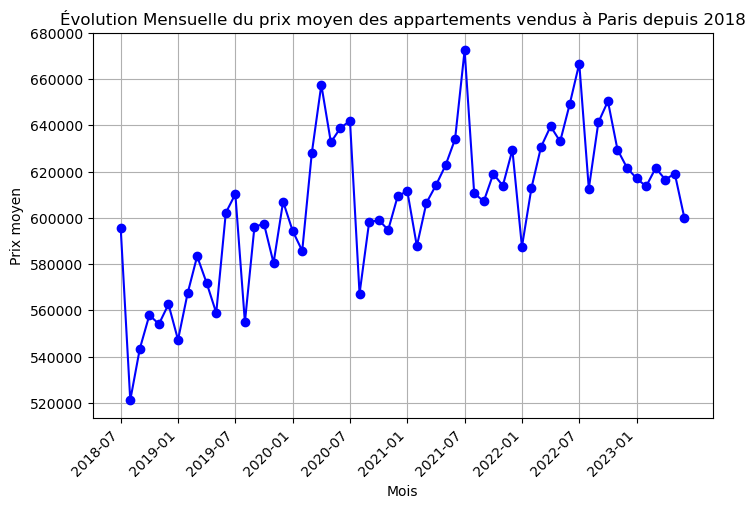

In [39]:
"""Application de la fonction"""
evolution_prix_mensuel(dvf)

In [36]:
"""La même chose, mais en nombre de ventes, à une fréquence soit annuelle soit mensuelle"""

def evolution_nombre(dvf, freq):
    #dvf : dataframe avec une colonne date_mutation et prix
    # freq = "Année" ou "Mois"
    
    #ne garder que les colonnes utiles
    dvf = dvf.loc[:,['date_mutation']]
    
    #on met à jour la periode
    period = ''
    if freq == "Année":
        period = "Y"
    elif freq == "Mois":
        period = "M"

    #fréquence qui apparaîtra dans le titre du graphique 
    freq_titre = ''
    if freq == "Année":
        freq_titre = "annuelle"
    elif freq == "Mois":
        freq_titre = "mensuelle"

    #création d'une colonne au format date_time
    dvf['date_time'] = pd.to_datetime(dvf['date_mutation'])

    # Convertir la colonne 'date_time' en format de période mensuelle
    dvf[freq] = dvf['date_time'].dt.to_period(period)
    
    # Grouper par mois et calculer la moyenne des prix
    dvf_grouped = dvf.groupby(freq).size().reset_index(name='nombre de ventes')

    # Convertir en str
    dvf_grouped[freq] = dvf_grouped[freq].astype(str)
    
    # Tracer l'évolution mensuelle des prix
    plt.figure(figsize=(8, 5))
    plt.plot(dvf_grouped[freq], dvf_grouped['nombre de ventes'], marker='o', linestyle='-', color='b')
    
    # Diminuer la fréquence des étiquettes sur l'axe des x
    n = len(dvf_grouped[freq])
    step = max(1, n // 10)  # Vous pouvez ajuster le pas selon vos besoins
    plt.xticks(dvf_grouped.index[::step], dvf_grouped[freq].iloc[::step], rotation=45, ha='right')
        
    # Ajouter des étiquettes et un titre
    plt.xlabel(freq)
    plt.ylabel('Nombre de ventes')
    plt.title(f"Évolution {freq_titre} du nombre de ventes d'appartements à Paris depuis 2018")
    
    # Afficher la grille
    plt.grid(True)

    # Chemin de sortie
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = f'evolution_{freq_titre}_nb_ventes.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Enregistrer la figure
    plt.savefig(output_path)

    # Afficher le graphique
    plt.show()

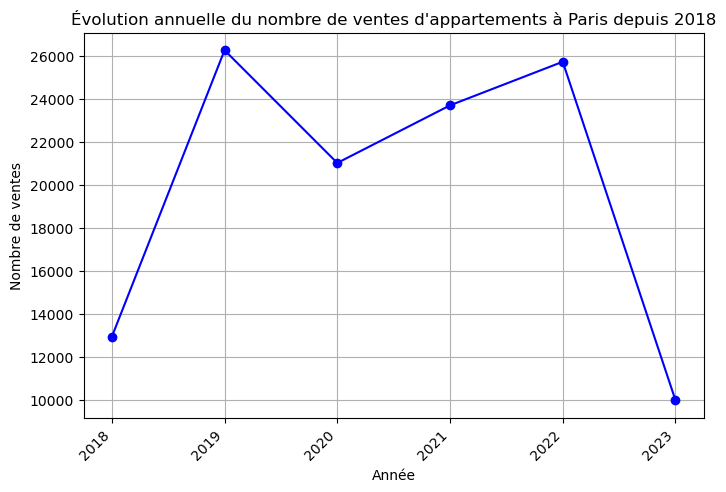

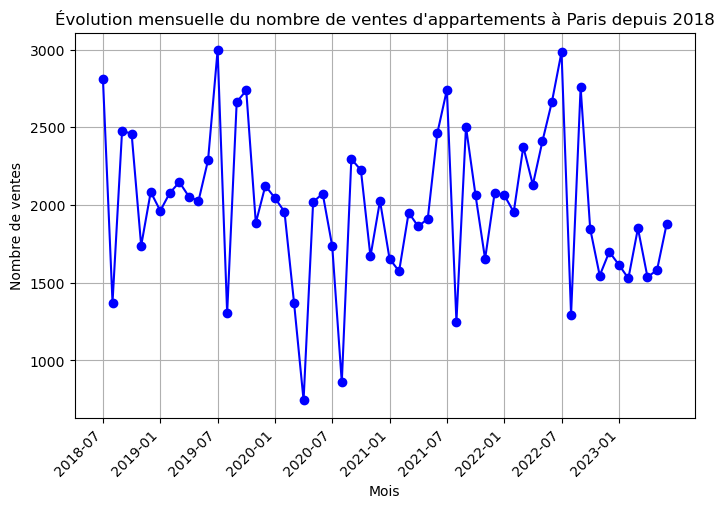

In [37]:
"""Application de la fonction"""
evolution_nombre(dvf, "Année")
evolution_nombre(dvf, "Mois")

**Remarques :**

Ces évolutions temporelles permettent de mettre en évidence plusieurs choses.

- D'abord, il y a une augmentation du prix moyen de l'immobilier en région parisienne ces dernières années. Cela justifie que nous nous restreigons aux ventes qui ont eu lieu entre 2021 et 2023, afin de se placer sur une période où le prix semble assez homogène.

- Il y a moins de ventes pour les années 2018 et 2023, mais cela vient du fait que ces fichiers sont tronqués (l'année 2023 ne contient que le premier trimestre, et 2018 que le dernier).

- Il semble y avoir une dimension cyclique dans le prix et dans le nombre des ventes. Ainsi, il y a toujours beaucoup moins de ventes durant le mois d'août, mais un pic au printemps (pour le nombre et le prix). Cela justifierait l'ajout d'une dimension temporelle dans notre modélisation.

- On peut remarquer l'effet de la crise sanitaire : il y a eu une chute du nombre de ventes pour les mois de mars et d'avril 2020.

**2) Visualisation graphique**

Ici, on représente le prix moyen (brut, et au m^2) des appartements vendus, selon l'arrondissement et le quartier parisien. Il s'agit de mettre en évidence que certains quartiers sont plus chers que d'autres, ce qui justifiera d'incorporer le quartier dans la modélisation.

In [40]:
"""Données administratives géographiques de paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')
paris_quartiers = gpd.read_file('2) Visualisation/Données_carto/paris_quartiers.geojson')
paris_quartiers = paris_quartiers[['c_quinsee', 'l_qu', 'geometry']]

In [41]:
def carte_prix_moyen_arrodissement(dvf):
    #dvf : geodataframe avec une colonne 'geometry'

    #on ne garde que les colonnes prix au m^2 et geometry
    dvf = dvf[['prix_au_m2_carrez', 'prix_au_m2_reel_bati', 'geometry']]  

    #on ajoute à chaque appartement les données administratives de son arrondissement
    dvf_geo = gpd.sjoin(dvf, paris_arrondissement, predicate = 'within')

    #regroupement selon les arrondissements et prix moyen au m2 carrez
    dvf_geo_group_carrez = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_carrez": "mean"})
      .reset_index())

    #regroupement selon les arrondissements et prix moyen au m2 réel
    dvf_geo_group_reel = (dvf_geo
      .groupby("INSEE_COG")
      .agg({"prix_au_m2_reel_bati": "mean"})
      .reset_index())

    #on ajoute aux données administratives les prix moyens
    paris_arrondissement_count_carrez = paris_arrondissement.merge(
        dvf_geo_group_carrez
    ).to_crs(2154)

    paris_arrondissement_count_reel = paris_arrondissement.merge(
        dvf_geo_group_reel
    ).to_crs(2154)

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Première carte (à gauche)
    paris_arrondissement_count_carrez.plot(ax=ax1, column="prix_au_m2_carrez", cmap="coolwarm", legend=True)
    ax1.set_title('Prix moyen du m^2 carrez - Carte 1')
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    
    # Deuxième carte (à droite)
    paris_arrondissement_count_reel.plot(ax=ax2, column="prix_au_m2_reel_bati", cmap="coolwarm", legend=True)
    ax2.set_title('Prix moyen du m^2 reel bati - Carte 2')
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.subplots_adjust(wspace=0.2)

    # Chemin de sortie
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = 'prix_moyen_arrondissements.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Enregistrer la figure
    plt.savefig(output_path)

    plt.show()

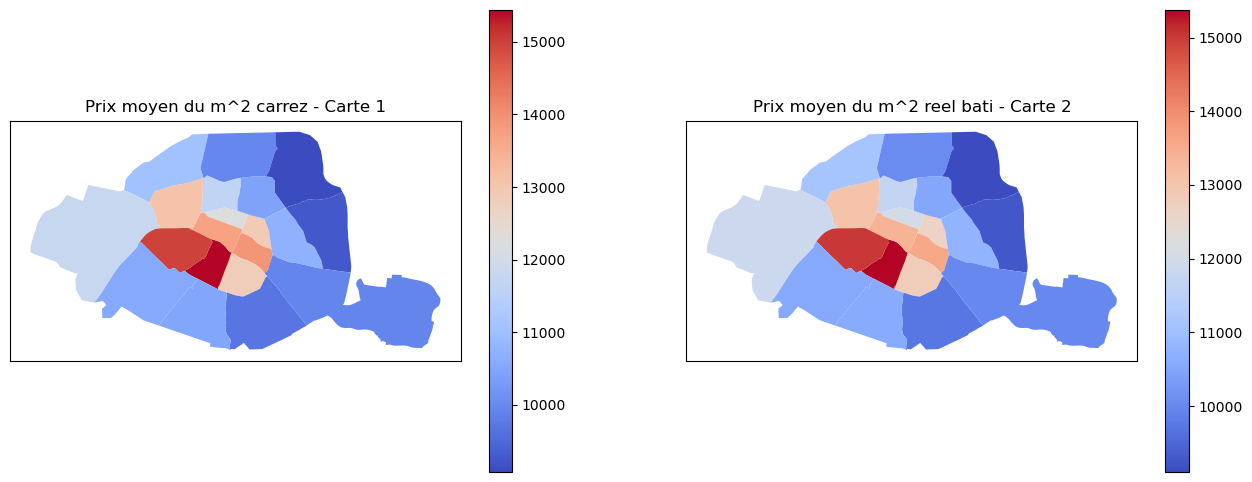

In [42]:
"""Application de la fonction"""

carte_prix_moyen_arrodissement(dvf)

In [43]:
def carte_prix_moyen_quartier(dvf):
    #dvf : geodataframe avec une colonne 'geometry'

    #on ne garde que les colonnes prix au m^2 et geometry
    dvf = dvf[['prix_au_m2_carrez', 'prix_au_m2_reel_bati', 'geometry']]

    #on ajoute à chaque appartement les données administratives de son arrondissement
    dvf_geo = gpd.sjoin(dvf, paris_quartiers, predicate = 'within')

    #regroupement selon les arrondissements et prix moyen au m2 carrez
    dvf_geo_group_carrez = (dvf_geo
      .groupby("l_qu")
      .agg({"prix_au_m2_carrez": "mean"})
      .reset_index())

    #regroupement selon les arrondissements et prix moyen au m2 réel
    dvf_geo_group_reel = (dvf_geo
      .groupby("l_qu")
      .agg({"prix_au_m2_reel_bati": "mean"})
      .reset_index())

    #on ajoute aux données administratives les prix moyens
    paris_quartiers_count_carrez = paris_quartiers.merge(
        dvf_geo_group_carrez
    ).to_crs(2154)

    paris_quartiers_count_reel = paris_quartiers.merge(
        dvf_geo_group_reel
    ).to_crs(2154)

    # Créez une figure avec deux sous-graphiques côte à côte
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Première carte (à gauche)
    paris_quartiers_count_carrez.plot(ax=ax1, column="prix_au_m2_carrez", cmap="coolwarm", legend=True)
    ax1.set_title('Prix moyen du m^2 carrez - Carte 1')
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    
    # Deuxième carte (à droite)
    paris_quartiers_count_reel.plot(ax=ax2, column="prix_au_m2_reel_bati", cmap="coolwarm", legend=True)
    ax2.set_title('Prix moyen du m^2 reel - Carte 2')
    ax2.set_xticks([], [])
    ax2.set_yticks([], [])

    # Ajustez l'espacement entre les sous-graphiques
    plt.subplots_adjust(wspace=0.2)

    # Enregistrez la figure dans le dossier spécifié
    output_folder = '2) Visualisation/Sorties_graph'
    output_filename = 'prix_moyen_quartiers.png'
    output_path = os.path.join(output_folder, output_filename)
    
    # Assurez-vous que le dossier de sortie existe
    os.makedirs(output_folder, exist_ok=True)
    
    # Enregistrez la figure
    plt.savefig(output_path)

    plt.show()

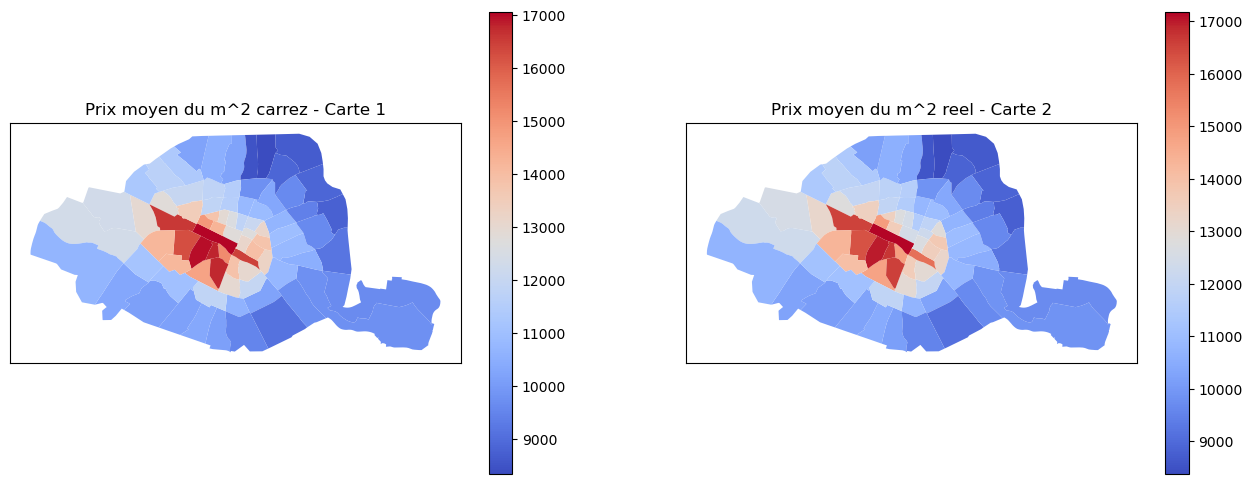

In [72]:
"""Application de la fonction"""

carte_prix_moyen_quartier(dvf)

In [70]:
from Visualisation import carte_prix_moyen_quartier_py

In [71]:
carte_prix_moyen_quartier_py(dvf)

NameError: name 'gpd' is not defined